# Análise dos Resultados dos Experimentos com LLMs

Este notebook lê os resultados brutos da bateria de testes, agrega os dados calculando as médias das execuções e realiza análises preliminares sobre os dados.

In [6]:
# Instala as bibliotecas necessárias (descomente se precisar)
# %pip install pandas spacy tqdm wordcloud matplotlib
# !python -m spacy download en_core_web_sm

import os
import json
import pandas as pd
import numpy as np
from collections import Counter
import spacy
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
OUTPUTS_DIR = 'outputs'

# Carregando o modelo de inglês do spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Modelo 'en_core_web_sm' não encontrado. Baixando agora...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    
print("Modelo spaCy em inglês carregado com sucesso.")

Modelo 'en_core_web_sm' não encontrado. Baixando agora...
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Modelo spaCy em inglês carregado com sucesso.


## Passo 1: Ler e Estruturar Todos os Arquivos JSON

Nesta etapa, o código varre a pasta `outputs/`, lê cada arquivo `.json` de resultado, extrai as informações relevantes (prompt, debate, modelo, notas, etc.) e os organiza em um único DataFrame do Pandas.

In [20]:
all_runs_data = []

tqdm.pandas(desc="Lendo arquivos JSON")

file_paths = []
for root, dirs, files in os.walk(OUTPUTS_DIR):
    for filename in files:
        if filename.endswith('.json'):
            file_paths.append(os.path.join(root, filename))

for file_path in tqdm(file_paths, desc="Processando Arquivos"):
    try:
        parts = file_path.split(os.sep)
        prompt_num = int(parts[1].split('_')[1])
        debate_num = int(parts[2].split('_')[1])
        model_name = parts[3].split('_')[0]
        run_num = int(parts[3].split('_')[2].split('.')[0])
    except (ValueError, IndexError):
        continue

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if "error" in data:
            continue

        for debater in data.get('debaters', []):
            debater_name = debater.get('name')
            performance_analysis = debater.get('performance_evaluation', 
                                              debater.get('performance', {}).get('performance_analysis', ''))

            # --- LÓGICA CORRIGIDA AQUI ---
            if prompt_num == 1:
                # Se for Prompt 1, pega o score direto e cria um registro único
                overall_score = debater.get('overall_score')
                if overall_score is not None:
                    all_runs_data.append({
                        'prompt': prompt_num,
                        'debate': debate_num,
                        'model': model_name,
                        'run': run_num,
                        'debater': debater_name,
                        'criterion': 'overall_score', # Usamos um nome de critério padrão
                        'score': overall_score,
                        'analysis_text': performance_analysis
                    })
            else:
                # Para os outros prompts, continua com a lógica anterior
                scores_data = debater.get('scores', {})
                if not scores_data:
                    scores_data = {k: v.get('score') for k, v in debater.get('evaluation_aspects', {}).items()}

                for criterion, score in scores_data.items():
                    all_runs_data.append({
                        'prompt': prompt_num,
                        'debate': debate_num,
                        'model': model_name,
                        'run': run_num,
                        'debater': debater_name,
                        'criterion': criterion,
                        'score': score,
                        'analysis_text': performance_analysis
                    })
    except Exception as e:
        print(f"Erro ao ler o arquivo JSON {file_path}: {e}")

raw_df = pd.DataFrame(all_runs_data)
print(f"Leitura concluída. Total de {len(raw_df)} registros lidos.")
display(raw_df.head())







Processando Arquivos: 100%|██████████| 576/576 [00:00<00:00, 747.72it/s]


Leitura concluída. Total de 11646 registros lidos.


,prompt,debate,model,run,debater,criterion,score,analysis_text
0,1,1,claude,1,Debater 1,overall_score,6.5,"O Debater 1 demonstrou competência básica, mas..."
1,1,1,claude,1,Debater 2,overall_score,8.5,O Debater 2 apresentou o melhor desempenho ger...
2,1,1,claude,1,Debater 3,overall_score,7.5,A Debater 3 demonstrou desempenho sólido e con...
3,1,1,claude,1,Debater 4,overall_score,7.0,O Debater 4 apresentou contribuições valiosas ...
4,1,1,claude,2,DEBATER1,overall_score,6.5,O Debatedor 1 demonstrou uma abordagem equilib...


## Passo 2: Agregar Resultados e Calcular Médias

Agora, agrupamos os dados para cada combinação de (prompt, debate, modelo, debatedor, critério) e calculamos a média das notas das 3 execuções. O resultado é salvo em um novo arquivo `aggregated_results.csv` para facilitar análises futuras.

In [21]:
aggregation_cols = ['prompt', 'debate', 'model', 'debater', 'criterion']
aggregated_scores_df = raw_df.groupby(aggregation_cols)['score'].mean().reset_index()

aggregated_scores_df.to_csv('aggregated_results.csv', index=False)
print("Resultados agregados salvos em 'aggregated_results.csv'")
aggregated_scores_df.head()

Resultados agregados salvos em 'aggregated_results.csv'


,prompt,debate,model,debater,criterion,score
0,1,1,claude,DEBATER1,overall_score,6.5
1,1,1,claude,DEBATER2,overall_score,8.5
2,1,1,claude,DEBATER3,overall_score,7.5
3,1,1,claude,DEBATER4,overall_score,7.0
4,1,1,claude,Debater 1,overall_score,6.5


In [19]:
# Célula 9 (VERSÃO CORRIGIDA)

# Filtra apenas os dados do Prompt 1
prompt1_df = raw_df[raw_df['prompt'] == 1].copy()

# Remove duplicatas, pois o overall_score é o mesmo para todos os critérios de uma mesma execução
prompt1_scores = prompt1_df.drop_duplicates(subset=['debate', 'model', 'run', 'debater'])

# Encontra o vencedor para cada execução individual usando a nova coluna 'overall_score'
winners_per_run = prompt1_scores.loc[prompt1_scores.groupby(['debate', 'model', 'run'])['overall_score'].idxmax()]

# O resto do código continua igual...
final_winners_p1 = winners_per_run.groupby(['debate', 'model'])['debater'].agg(lambda x: x.mode().iloc[0]).reset_index()
winner_pivot_p1 = final_winners_p1.pivot_table(index='debate', columns='model', values='debater', aggfunc='first')

winner_pivot_p1.to_csv('aggregated_results_prompt_1_winners.csv')
print("Resultados de vencedores para o Prompt 1 salvos em 'aggregated_results_prompt_1_winners.csv'")

# (O resto do código de cálculo de discordância continua igual...)

Resultados de vencedores para o Prompt 1 salvos em 'aggregated_results_prompt_1_winners.csv'


## Passo 3: Análises Iniciais

Com os dados agregados, podemos começar a extrair insights.

### Análise 1: Discordância dos Modelos na Escolha do Vencedor

Calculamos o score total para cada debatedor em cada teste e verificamos em quantos casos os modelos (GPT, Gemini, Claude) apontaram vencedores diferentes para o mesmo debate.

In [9]:
debater_total_scores = aggregated_scores_df.groupby(['prompt', 'debate', 'model', 'debater'])['score'].sum().reset_index()
winners = debater_total_scores.loc[debater_total_scores.groupby(['prompt', 'debate', 'model'])['score'].idxmax()]
winner_pivot = winners.pivot_table(index=['prompt', 'debate'], columns='model', values='debater', aggfunc='first')

total_comparisons = len(winner_pivot)
disagreements = 0
for index, row in winner_pivot.iterrows():
    if len(set(row.dropna())) > 1:
        disagreements += 1

disagreement_rate = (disagreements / total_comparisons) * 100 if total_comparisons > 0 else 0

print(f"Em {total_comparisons} debates avaliados pelos 3 modelos:")
print(f"Houve discordância sobre o vencedor em {disagreements} casos.")
print(f"Taxa de Discordância entre os modelos: {disagreement_rate:.2f}%")

Em 32 debates avaliados pelos 3 modelos:
Houve discordância sobre o vencedor em 21 casos.
Taxa de Discordância entre os modelos: 65.62%


### Análise 2: Nuvem de Palavras das Justificativas dos Modelos

Processamos o texto das análises de performance para descobrir visualmente quais termos cada modelo mais utiliza ao justificar suas avaliações. O texto passa por um processo de limpeza, remoção de stopwords em inglês e lematização. As três nuvens de palavras geradas serão salvas como arquivos .png.

Gerando nuvem de palavras para o modelo 'claude'...


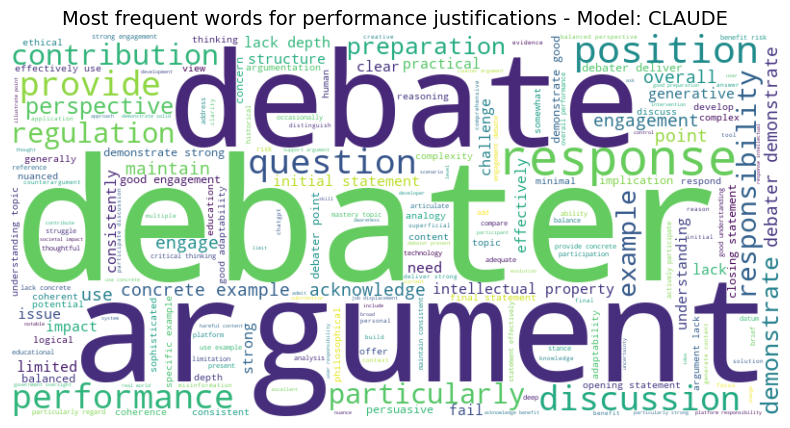

Nuvem de palavras salva como 'wordcloud_claude.png'
Gerando nuvem de palavras para o modelo 'gemini'...


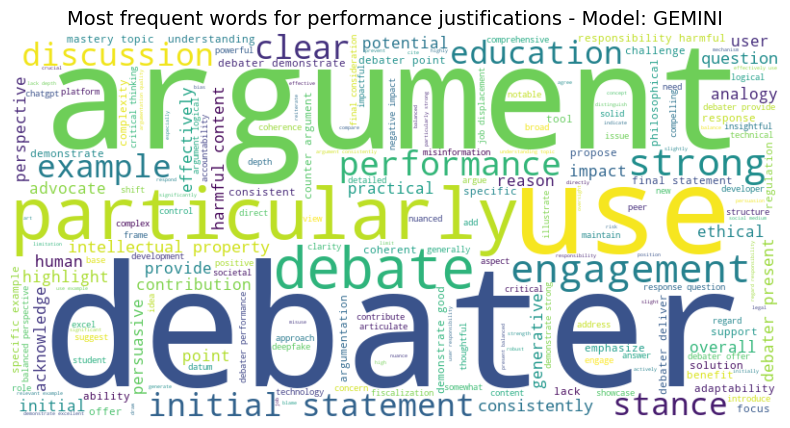

Nuvem de palavras salva como 'wordcloud_gemini.png'
Gerando nuvem de palavras para o modelo 'gpt4o'...


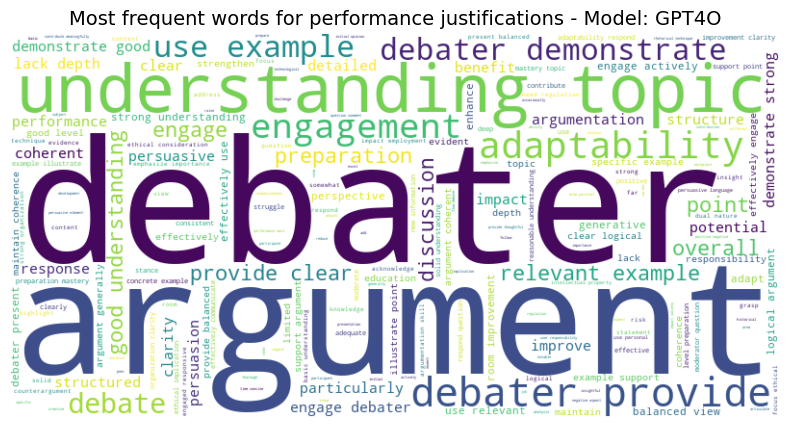

Nuvem de palavras salva como 'wordcloud_gpt4o.png'


In [11]:
def preprocess_text(text, stopwords):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stopwords and len(token.lemma_) > 2]
    return lemmas

# Pega as stopwords do spaCy para inglês
stopwords = nlp.Defaults.stop_words
unique_texts_df = raw_df.drop_duplicates(subset=['prompt', 'debate', 'model', 'debater'])

# Gera uma word cloud para cada modelo
for model in sorted(unique_texts_df['model'].unique()):
    print(f"Gerando nuvem de palavras para o modelo '{model}'...")
    
    # Concatena todos os textos de análise para o modelo atual
    all_text_for_model = " ".join(unique_texts_df[unique_texts_df['model'] == model]['analysis_text'])
    
    # Processa o texto
    lemmas = preprocess_text(all_text_for_model, stopwords)
    full_lemmas_text = " ".join(lemmas)
    
    # Cria e gera a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(full_lemmas_text)
    
    # Exibe a imagem
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most frequent words for performance justifications - Model: {model.upper()}", fontsize=14)
    
    # Salva a figura
    output_filename = f"wordcloud_{model}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Nuvem de palavras salva como '{output_filename}'")

--- Análise 3.3: Gerando Nuvem de Palavras para os Critérios do Prompt 1 ---


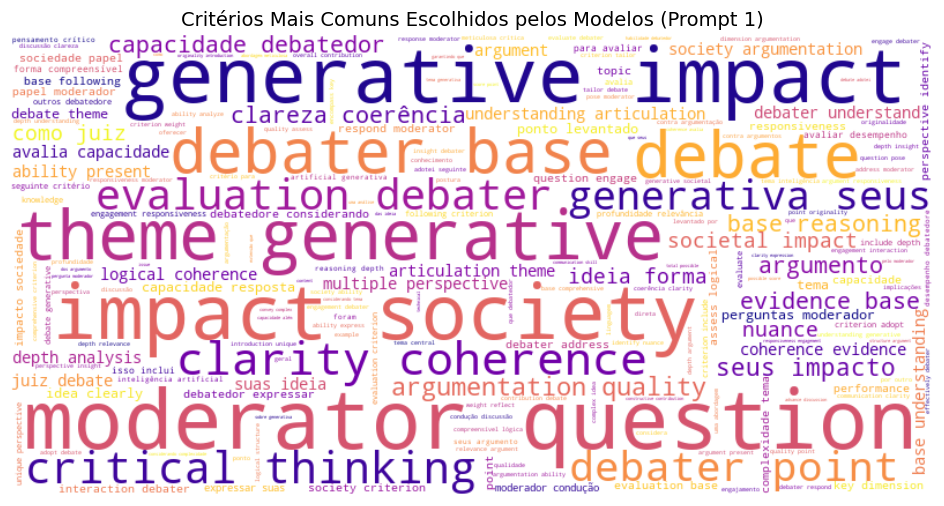

Nuvem de palavras dos critérios salva como 'wordcloud_prompt1_criteria.png'


In [22]:
print("--- Análise 3.3: Gerando Nuvem de Palavras para os Critérios do Prompt 1 ---")

# Filtra o DataFrame bruto para pegar apenas os dados do Prompt 1
prompt1_df = raw_df[raw_df['prompt'] == 1].copy()

# O campo 'evaluation_criteria' não está no DataFrame, então precisamos ler os arquivos novamente
# mas de forma mais simples, apenas para pegar esse campo.
criteria_texts = []
for root, dirs, files in os.walk(os.path.join(OUTPUTS_DIR, 'prompt_1')):
    for filename in files:
        if filename.endswith('.json'):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                if "evaluation_criteria" in data:
                    criteria_texts.append(data["evaluation_criteria"])
            except Exception as e:
                print(f"Erro ao ler {file_path}: {e}")

# Concatena todos os textos de critérios em um único bloco de texto
full_criteria_text = " ".join(criteria_texts)

if full_criteria_text:
    # Reutiliza a função de pré-processamento e stopwords em inglês
    lemmas = preprocess_text(full_criteria_text, stopwords)
    processed_text = " ".join(lemmas)

    # Cria e gera a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma', random_state=42).generate(processed_text)

    # Exibe a imagem
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Critérios Mais Comuns Escolhidos pelos Modelos (Prompt 1)", fontsize=14)
    
    # Salva a figura
    output_filename = "wordcloud_prompt1_criteria.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Nuvem de palavras dos critérios salva como '{output_filename}'")
else:
    print("Nenhum texto de 'evaluation_criteria' encontrado para o Prompt 1.")

### Juntando

In [53]:
import pandas as pd
import numpy as np

print("--- [CÉLULA 1 - TENTATIVA FINAL] PROCESSANDO O SOFT VOTING ---")

JUDGES_EVALUATION_PATH = 'avaliacao_jurados/judges_evaluation.csv'
# Mapeamento com chaves em minúsculo para corresponder ao texto limpo
SCORE_MAPPING = {'muito ruim': 1, 'ruim': 2, 'regular': 3, 'bom': 4, 'muito bom': 5}
judges_soft_vote_ranking_df = pd.DataFrame()

try:
    df = pd.read_csv(JUDGES_EVALUATION_PATH, sep=';', dtype=str) # Lê tudo como texto
    
    # Renomeia as colunas de ID
    df.rename(columns={df.columns[1]: 'debate', df.columns[-1]: 'judge_id'}, inplace=True)
    
    # Lista para guardar os dados no formato longo (mais seguro)
    long_data = []
    
    # Mapeamento de posições de colunas para cada debatedor
    debater_positions = [(3, 1), (13, 2), (23, 3), (34, 4), (45, 5)]
    criteria_names = ['org_clarity', 'examples', 'argumentation', 'coherence', 'persuasion', 'engagement', 'adaptability', 'preparation', 'topic_mastery']

    for index, row in df.iterrows():
        debate_id = row['debate']
        judge_id = row['judge_id']
        
        for start_col, debater_id in debater_positions:
            scores = row[start_col : start_col + 9]
            if not scores.isnull().all():
                for i, score_text in enumerate(scores):
                    long_data.append({
                        'debate': debate_id,
                        'judge_id': judge_id,
                        'debater_id': debater_id,
                        'criterion': criteria_names[i],
                        'score_text': score_text
                    })

    long_df = pd.DataFrame(long_data)
    
    # --- ETAPA DE LIMPEZA CRUCIAL ---
    long_df.dropna(subset=['score_text'], inplace=True) # Remove linhas sem nota
    long_df['score_text_cleaned'] = long_df['score_text'].str.strip().str.lower()
    
    # Converte scores usando o texto limpo
    long_df['score'] = long_df['score_text_cleaned'].map(SCORE_MAPPING)
    long_df.dropna(subset=['score'], inplace=True) # Remove linhas onde a conversão falhou
    
    # Agregação e Ranking
    avg_scores = long_df.groupby(['debate', 'debater_id'])['score'].mean().reset_index()
    avg_scores.rename(columns={'score': 'total_soft_score'}, inplace=True)
    
    avg_scores['debater'] = "DEBATER_" + avg_scores['debater_id'].astype(str)
    
    # Garante que a coluna 'debate' seja numérica para o groupby
    avg_scores['debate'] = pd.to_numeric(avg_scores['debate'], errors='coerce')
    avg_scores.dropna(subset=['debate'], inplace=True)
    avg_scores['debate'] = avg_scores['debate'].astype(int)
    
    avg_scores['rank'] = avg_scores.groupby('debate')['total_soft_score'].rank(method='dense', ascending=False).astype(int)
    
    judges_soft_vote_ranking_df = avg_scores.sort_values(by=['debate', 'rank'])

    print("\n--- RESULTADO FINAL DO SOFT VOTING ---")
    if not judges_soft_vote_ranking_df.empty:
        print(">>> SUCESSO! DataFrame do SOFT VOTING gerado corretamente.")
        display(judges_soft_vote_ranking_df)
        judges_soft_vote_ranking_df.to_csv('gt_judges_soft_vote_ranking.csv', index=False)
        print(">>> Arquivo 'gt_judges_soft_vote_ranking.csv' salvo.")
    else:
        print(">>> FALHA: O DataFrame final ainda está vazio, mesmo após a limpeza.")

except Exception as e:
    print(f"\n--- OCORREU UM ERRO DURANTE O PROCESSAMENTO ---")
    print(f"ERRO: {e}")

--- [CÉLULA 1 - TENTATIVA FINAL] PROCESSANDO O SOFT VOTING ---

--- RESULTADO FINAL DO SOFT VOTING ---
>>> SUCESSO! DataFrame do SOFT VOTING gerado corretamente.


,debate,debater_id,total_soft_score,debater,rank
1,1,2,4.333333,DEBATER_2,1
2,1,3,4.066667,DEBATER_3,2
0,1,1,2.755556,DEBATER_1,3
3,1,4,2.755556,DEBATER_4,3
42,2,5,4.681818,DEBATER_5,1
...,...,...,...,...,...
30,17,1,3.000000,DEBATER_1,4
35,18,2,4.488889,DEBATER_2,1
36,18,3,4.288889,DEBATER_3,2
34,18,1,4.244444,DEBATER_1,3


>>> Arquivo 'gt_judges_soft_vote_ranking.csv' salvo.


In [55]:
import pandas as pd
import numpy as np

print("\n--- [CÉLULA 2] INICIANDO PROCESSAMENTO DO HARD VOTING ---")

JUDGES_EVALUATION_PATH = 'avaliacao_jurados/judges_evaluation.csv'
judges_hard_vote_ranking_df = pd.DataFrame() # Reseta o dataframe

try:
    # A lista de todos os debatedores que já processamos no SOFT VOTE é a nossa base
    all_debaters_per_debate = judges_soft_vote_ranking_df[['debate', 'debater']].drop_duplicates()
    
    # Carrega o arquivo dos juízes novamente para esta tarefa isolada
    judges_df_hard = pd.read_csv(JUDGES_EVALUATION_PATH, sep=';')
    
    # Acessa as colunas de debate e voto pela posição para evitar erros
    hard_voting_data = judges_df_hard.iloc[:, [1, -3]].copy()
    hard_voting_data.columns = ['debate', 'voted_debaters']
    
    # Limpa os dados
    hard_voting_data.dropna(subset=['voted_debaters'], inplace=True)
    hard_voting_data['debate'] = pd.to_numeric(hard_voting_data['debate'], errors='coerce').dropna().astype(int)
    
    # Processa os votos, incluindo os múltiplos
    processed_votes = []
    for _, row in hard_voting_data.iterrows():
        debaters = str(row['voted_debaters']).replace(' ', '').split(',')
        for debater_id in debaters:
            if debater_id.isdigit():
                processed_votes.append({'debate': int(row['debate']), 'debater': f"DEBATER_{int(debater_id)}"})
    
    # Conta os votos de cada debatedor
    hard_vote_counts = pd.DataFrame(processed_votes).groupby(['debate', 'debater']).size().reset_index(name='votes')

    # Junta a contagem de votos com a lista de todos os debatedores
    # Preenche com 0 os que não receberam votos
    judges_hard_vote_full = pd.merge(all_debaters_per_debate, hard_vote_counts, on=['debate', 'debater'], how='left').fillna({'votes': 0})
    
    # Cria o ranking final baseado na contagem de votos
    judges_hard_vote_full['rank'] = judges_hard_vote_full.groupby('debate')['votes'].rank(method='dense', ascending=False).astype(int)
    judges_hard_vote_ranking_df = judges_hard_vote_full.sort_values(by=['debate', 'rank'])
    
    print(">>> Ranking do HARD VOTING (completo) gerado com sucesso.")
    judges_hard_vote_ranking_df.to_csv('gt_judges_hard_vote_ranking.csv', index=False)
    print(">>> Arquivo 'gt_judges_hard_vote_ranking.csv' salvo.")
    display(judges_hard_vote_ranking_df.head())

except Exception as e:
    print(f"Ocorreu um erro na Célula 2: {e}")


--- [CÉLULA 2] INICIANDO PROCESSAMENTO DO HARD VOTING ---
>>> Ranking do HARD VOTING (completo) gerado com sucesso.
>>> Arquivo 'gt_judges_hard_vote_ranking.csv' salvo.


,debate,debater,votes,rank
0,1,DEBATER_2,3.0,1
1,1,DEBATER_3,2.0,2
2,1,DEBATER_1,0.0,3
3,1,DEBATER_4,0.0,3
4,2,DEBATER_5,5.0,1


In [1]:
import pandas as pd
import numpy as np

print("\n--- [CÉLULA FINAL] PROCESSANDO A AUTOAVALIAÇÃO (COM LISTA MESTRE) ---")

SELF_ASSESSMENT_PATH = 'autoavaliacao/autoavaliacao_respostas.csv'
# Usamos o Hard Voting como a fonte da verdade sobre quem participou de cada debate
ALL_DEBATERS_PATH = 'gt_judges_hard_vote_ranking.csv' 
self_assessment_ranking_df = pd.DataFrame()

try:
    # Carrega a lista mestre de todos os debatedores de cada debate
    all_debaters_per_debate = pd.read_csv(ALL_DEBATERS_PATH)[['debate', 'debater']].drop_duplicates()
    
    # Carrega e processa os votos da autoavaliação
    sa_df = pd.read_csv(SELF_ASSESSMENT_PATH)
    sa_df.rename(columns={'Grupo': 'debate'}, inplace=True)
    
    sa_df['winner_vote'] = sa_df['melhor_debatedor'].str.extract(r'(\d+)')
    sa_df.dropna(subset=['winner_vote'], inplace=True)
    sa_df['debater_voted'] = "DEBATER_" + sa_df['winner_vote'].astype(str)
    
    # Conta os votos (apenas para quem recebeu voto)
    sa_vote_counts = sa_df.groupby(['debate', 'debater_voted']).size().reset_index(name='votes')
    sa_vote_counts.rename(columns={'debater_voted': 'debater'}, inplace=True)

    # --- A MÁGICA ACONTECE AQUI ---
    # Junta a lista mestre com a contagem de votos.
    # Quem não estiver na contagem de votos (recebeu 0 votos), terá o valor preenchido com 0.
    self_assessment_full = pd.merge(all_debaters_per_debate, sa_vote_counts, on=['debate', 'debater'], how='left').fillna({'votes': 0})
    
    # Garante que a coluna de votos seja do tipo inteiro
    self_assessment_full['votes'] = self_assessment_full['votes'].astype(int)

    # Cria o ranking final completo
    self_assessment_full['rank'] = self_assessment_full.groupby('debate')['votes'].rank(method='dense', ascending=False).astype(int)
    self_assessment_ranking_df = self_assessment_full.sort_values(by=['debate', 'rank'])
    
    print(">>> Ranking da Autoavaliação (COMPLETO) gerado com sucesso.")
    self_assessment_ranking_df.to_csv('gt_self_assessment_ranking.csv', index=False)
    print(">>> Arquivo 'gt_self_assessment_ranking.csv' salvo.")
    display(self_assessment_ranking_df)

except Exception as e:
    print(f"Ocorreu um erro na Célula de Autoavaliação: {e}")


--- [CÉLULA FINAL] PROCESSANDO A AUTOAVALIAÇÃO (COM LISTA MESTRE) ---
>>> Ranking da Autoavaliação (COMPLETO) gerado com sucesso.
>>> Arquivo 'gt_self_assessment_ranking.csv' salvo.


,debate,debater,votes,rank
0,1,DEBATER_2,2,1
3,1,DEBATER_4,1,2
1,1,DEBATER_3,0,3
2,1,DEBATER_1,0,3
5,2,DEBATER_4,2,1
...,...,...,...,...
63,17,DEBATER_1,0,1
64,18,DEBATER_3,1,1
65,18,DEBATER_2,1,1
66,18,DEBATER_1,1,1
